In [1]:
!pip install -q flwr[simulation] torch torchvision

In [10]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [11]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 108.8 GB  | Proc size: 586.1 MB
GPU RAM Free: 14151MB | Used: 2017MB | Util  12% | Total 16376MB


In [12]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [30]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [31]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times = {}
        self.client_metrics = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [32]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [33]:
strategy = FedCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,  # <-- pass the new strategy here
    client_resources=client_resources,

)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-11 13:05:34,625	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 33215596953.0, 'accelerator_type:RTX': 1.0, 'memory': 67503059559.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1844) Epoch 9: train loss 0.038106, accuracy 0.562667 [repeated 5x across cluster]
(ClientAppActor pid=1844) [Client 6] evaluate, config: {}
(ClientAppActor pid=1844) Training time for Client 9: 23.07 seconds
(ClientAppActor pid=17632) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11692) [Client 7] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 21.987837553024292and 2habhhahah
this is tehb mode time [21.99]
This is ths last time not a fantasy 21.9000186920166and 7habhhahah
this is tehb mode time [21.99, 21.9]
This is ths last time not a fantasy 22.29568099975586and 8habhhahah
this is tehb mode time [21.99, 21.9, 22.3]
This is ths last time not a fantasy 23.070062398910522and 9habhhahah
this is tehb mode time [21.99, 21.9, 22.3, 23.07]
This is ths last time not a fantasy 21.977339267730713and 3habhhahah
this is tehb mode time [21.99, 21.9, 22.3, 23.07, 21.98]
This is ths last time not a fantasy 22.000871658325195and 0habhhahah
this is tehb mode time [21.99, 21.9, 22.3, 23.07, 21.98, 22.0]
This is ths last time not a fantasy 22.39858865737915and 4habhhahah
this is tehb mode time [21.99, 21.9, 22.3, 23.07, 21.98, 22.0, 22.4]
This is ths last time not a fantasy 21.725632905960083and 6habhhahah
this is tehb m

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24164) [Client 2] evaluate, config: {}
(ClientAppActor pid=24164) Epoch 8: train loss 0.024851, accuracy 0.720667 [repeated 2x across cluster]
(ClientAppActor pid=24164) Training time for Client 1: 20.41 seconds
(ClientAppActor pid=39348) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.18891406059265and 4habhhahah
this is tehb mode time [19.19]
This is ths last time not a fantasy 20.747142553329468and 5habhhahah
this is tehb mode time [19.19, 20.75]
This is ths last time not a fantasy 19.7822687625885and 7habhhahah
this is tehb mode time [19.19, 20.75, 19.78]
This is ths last time not a fantasy 19.93850326538086and 8habhhahah
this is tehb mode time [19.19, 20.75, 19.78, 19.94]
This is ths last time not a fantasy 19.06320858001709and 9habhhahah
this is tehb mode time [19.19, 20.75, 19.78, 19.94, 19.06]
This is ths last time not a fantasy 19.731545209884644and 3habhhahah
this is tehb mode time [19.19, 20.75, 19.78, 19.94, 19.06, 19.73]
This is ths last time not a fantasy 22.192704916000366and 6habhhahah
this is tehb mode time [19.19, 20.75, 19.78, 19.94, 19.06, 19.73, 22.19]
This is ths last time not a fantasy 20.411510705947876and 1habhhahah
this is tehb mode time [19.19, 20.75, 19.78, 19.94, 19.06, 19.73, 22.19, 20.41]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30764) [Client 5] evaluate, config: {}
(ClientAppActor pid=30764) Epoch 8: train loss 0.013866, accuracy 0.852000 [repeated 2x across cluster]
(ClientAppActor pid=30764) Training time for Client 2: 20.20 seconds
(ClientAppActor pid=12488) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11692) [Client 0] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 19.7619309425354and 8habhhahah
this is tehb mode time [19.76]
This is ths last time not a fantasy 20.069427967071533and 3habhhahah
this is tehb mode time [19.76, 20.07]
This is ths last time not a fantasy 19.31412386894226and 1habhhahah
this is tehb mode time [19.76, 20.07, 19.31]
This is ths last time not a fantasy 19.900073051452637and 4habhhahah
this is tehb mode time [19.76, 20.07, 19.31, 19.9]
This is ths last time not a fantasy 20.642394065856934and 0habhhahah
this is tehb mode time [19.76, 20.07, 19.31, 19.9, 20.64]
This is ths last time not a fantasy 19.28862690925598and 9habhhahah
this is tehb mode time [19.76, 20.07, 19.31, 19.9, 20.64, 19.29]
This is ths last time not a fantasy 19.17011594772339and 7habhhahah
this is tehb mode time [19.76, 20.07, 19.31, 19.9, 20.64, 19.29, 19.17]
This is ths last time not a fantasy 20.412746906280518and 5habhhahah
this 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30764) [Client 5] evaluate, config: {}
(ClientAppActor pid=30764) Epoch 8: train loss 0.007042, accuracy 0.925556 [repeated 2x across cluster]
(ClientAppActor pid=30764) Training time for Client 6: 20.56 seconds
(ClientAppActor pid=39348) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.842588663101196and 0habhhahah
this is tehb mode time [19.84]
This is ths last time not a fantasy 20.049841165542603and 9habhhahah
this is tehb mode time [19.84, 20.05]
This is ths last time not a fantasy 19.378318309783936and 4habhhahah
this is tehb mode time [19.84, 20.05, 19.38]
This is ths last time not a fantasy 19.667718410491943and 5habhhahah
this is tehb mode time [19.84, 20.05, 19.38, 19.67]
This is ths last time not a fantasy 19.385239839553833and 1habhhahah
this is tehb mode time [19.84, 20.05, 19.38, 19.67, 19.39]
This is ths last time not a fantasy 20.426272869110107and 2habhhahah
this is tehb mode time [19.84, 20.05, 19.38, 19.67, 19.39, 20.43]
This is ths last time not a fantasy 20.103214263916016and 8habhhahah
this is tehb mode time [19.84, 20.05, 19.38, 19.67, 19.39, 20.43, 20.1]
This is ths last time not a fantasy 20.557926416397095and 6habhhahah
this is tehb mode time [19.84, 20.05, 19.38, 19.67, 19.39, 20.43, 20.1, 20.56]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12488) Epoch 9: train loss 0.004263, accuracy 0.957556 [repeated 3x across cluster]
(ClientAppActor pid=12488) [Client 9] evaluate, config: {}
(ClientAppActor pid=12488) Training time for Client 7: 22.84 seconds
(ClientAppActor pid=11692) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.417004585266113and 1habhhahah
this is tehb mode time [19.42]
This is ths last time not a fantasy 19.416383743286133and 5habhhahah
this is tehb mode time [19.42, 19.42]
This is ths last time not a fantasy 20.100138664245605and 9habhhahah
this is tehb mode time [19.42, 19.42, 20.1]
This is ths last time not a fantasy 19.971322536468506and 4habhhahah
this is tehb mode time [19.42, 19.42, 20.1, 19.97]
This is ths last time not a fantasy 19.66187357902527and 6habhhahah
this is tehb mode time [19.42, 19.42, 20.1, 19.97, 19.66]
This is ths last time not a fantasy 19.3084979057312and 2habhhahah
this is tehb mode time [19.42, 19.42, 20.1, 19.97, 19.66, 19.31]
This is ths last time not a fantasy 19.651692152023315and 8habhhahah
this is tehb mode time [19.42, 19.42, 20.1, 19.97, 19.66, 19.31, 19.65]
This is ths last time not a fantasy 20.40991473197937and 0habhhahah
this is tehb mode time [19.42, 19.42, 20.1, 19.97, 19.66, 19.31, 19.65, 20.41]
This is ths la

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24164) Epoch 7: train loss 0.004200, accuracy 0.962667 [repeated 4x across cluster]
(ClientAppActor pid=24164) [Client 9] evaluate, config: {}
(ClientAppActor pid=24164) Training time for Client 3: 18.05 seconds
(ClientAppActor pid=11692) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 17.916462898254395and 7habhhahah
this is tehb mode time [17.92]
This is ths last time not a fantasy 22.09395956993103and 1habhhahah
this is tehb mode time [17.92, 22.09]
This is ths last time not a fantasy 18.052196502685547and 3habhhahah
this is tehb mode time [17.92, 22.09, 18.05]
This is ths last time not a fantasy 17.38270401954651and 6habhhahah
this is tehb mode time [17.92, 22.09, 18.05, 17.38]
This is ths last time not a fantasy 21.609832763671875and 2habhhahah
this is tehb mode time [17.92, 22.09, 18.05, 17.38, 21.61]
This is ths last time not a fantasy 17.51782774925232and 4habhhahah
this is tehb mode time [17.92, 22.09, 18.05, 17.38, 21.61, 17.52]
This is ths last time not a fantasy 17.358189582824707and 8habhhahah
this is tehb mode time [17.92, 22.09, 18.05, 17.38, 21.61, 17.52, 17.36]
This is ths last time not a fantasy 17.324140787124634and 9habhhahah
this is tehb mode time [17.92, 22.09, 18.05, 17.38, 21.61, 17.52, 17.36, 17.32]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12488) Epoch 9: train loss 0.005591, accuracy 0.938667 [repeated 4x across cluster]
(ClientAppActor pid=12488) Training time for Client 0: 22.20 seconds
(ClientAppActor pid=12488) [Client 2] evaluate, config: {}
(ClientAppActor pid=39348) [Client 5] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.362403869628906and 9habhhahah
this is tehb mode time [21.36]
This is ths last time not a fantasy 21.662749528884888and 8habhhahah
this is tehb mode time [21.36, 21.66]
This is ths last time not a fantasy 17.389997959136963and 5habhhahah
this is tehb mode time [21.36, 21.66, 17.39]
This is ths last time not a fantasy 22.203502893447876and 0habhhahah
this is tehb mode time [21.36, 21.66, 17.39, 22.2]
This is ths last time not a fantasy 21.498308181762695and 4habhhahah
this is tehb mode time [21.36, 21.66, 17.39, 22.2, 21.5]
This is ths last time not a fantasy 18.066653966903687and 1habhhahah
this is tehb mode time [21.36, 21.66, 17.39, 22.2, 21.5, 18.07]
This is ths last time not a fantasy 16.620896100997925and 2habhhahah
this is tehb mode time [21.36, 21.66, 17.39, 22.2, 21.5, 18.07, 16.62]
This is ths last time not a fantasy 17.302761793136597and 3habhhahah
this is tehb mode time [21.36, 21.66, 17.39, 22.2, 21.5, 18.07, 16.62, 17.3]
This is ths la

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11692) [Client 0] evaluate, config: {}
(ClientAppActor pid=11692) Epoch 8: train loss 0.003961, accuracy 0.958667 [repeated 4x across cluster]
(ClientAppActor pid=11692) Training time for Client 6: 20.19 seconds
(ClientAppActor pid=17632) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.161189079284668and 8habhhahah
this is tehb mode time [20.16]
This is ths last time not a fantasy 19.416749238967896and 1habhhahah
this is tehb mode time [20.16, 19.42]
This is ths last time not a fantasy 19.43610715866089and 0habhhahah
this is tehb mode time [20.16, 19.42, 19.44]
This is ths last time not a fantasy 19.779303312301636and 2habhhahah
this is tehb mode time [20.16, 19.42, 19.44, 19.78]
This is ths last time not a fantasy 19.864065647125244and 5habhhahah
this is tehb mode time [20.16, 19.42, 19.44, 19.78, 19.86]
This is ths last time not a fantasy 18.844141006469727and 3habhhahah
this is tehb mode time [20.16, 19.42, 19.44, 19.78, 19.86, 18.84]
This is ths last time not a fantasy 19.36926794052124and 4habhhahah
this is tehb mode time [20.16, 19.42, 19.44, 19.78, 19.86, 18.84, 19.37]
This is ths last time not a fantasy 19.935253143310547and 9habhhahah
this is tehb mode time [20.16, 19.42, 19.44, 19.78, 19.86, 18.84, 19.37, 19.94]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11692) [Client 4] evaluate, config: {}
(ClientAppActor pid=11692) Epoch 8: train loss 0.005555, accuracy 0.945111 [repeated 2x across cluster]
(ClientAppActor pid=11692) Training time for Client 6: 20.43 seconds
(ClientAppActor pid=1844) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.260196208953857and 7habhhahah
this is tehb mode time [20.26]
This is ths last time not a fantasy 19.196476221084595and 0habhhahah
this is tehb mode time [20.26, 19.2]
This is ths last time not a fantasy 20.23159623146057and 8habhhahah
this is tehb mode time [20.26, 19.2, 20.23]
This is ths last time not a fantasy 19.54925012588501and 9habhhahah
this is tehb mode time [20.26, 19.2, 20.23, 19.55]
This is ths last time not a fantasy 19.593639373779297and 4habhhahah
this is tehb mode time [20.26, 19.2, 20.23, 19.55, 19.59]
This is ths last time not a fantasy 19.68514895439148and 1habhhahah
this is tehb mode time [20.26, 19.2, 20.23, 19.55, 19.59, 19.69]
This is ths last time not a fantasy 19.604731798171997and 3habhhahah
this is tehb mode time [20.26, 19.2, 20.23, 19.55, 19.59, 19.69, 19.6]
This is ths last time not a fantasy 20.425190210342407and 6habhhahah
this is tehb mode time [20.26, 19.2, 20.23, 19.55, 19.59, 19.69, 19.6, 20.43]
This is ths last

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=12488) [Client 0] evaluate, config: {}
(ClientAppActor pid=12488) Training time for Client 5: 20.48 seconds
(ClientAppActor pid=12488) Epoch 8: train loss 0.000180, accuracy 1.000000
(ClientAppActor pid=30764) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 582.42s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.059087431025505066
INFO :      		round 2: 0.04317164099216461
INFO :      		round 3: 0.04620158540010452
INFO :      		round 4: 0.05399114774465561
INFO :      		round 5: 0.06171587011814117
INFO :      		round 6: 0.06685536856651306
INFO :      		round 7: 0.07144101390838623
INFO :      		round 8: 0.07506648166179657
INFO :      		round 9: 0.07575845985412596
INFO :      		round 10: 0.08028348743915557
INFO :      


History (loss, distributed):
	round 1: 0.059087431025505066
	round 2: 0.04317164099216461
	round 3: 0.04620158540010452
	round 4: 0.05399114774465561
	round 5: 0.06171587011814117
	round 6: 0.06685536856651306
	round 7: 0.07144101390838623
	round 8: 0.07506648166179657
	round 9: 0.07575845985412596
	round 10: 0.08028348743915557

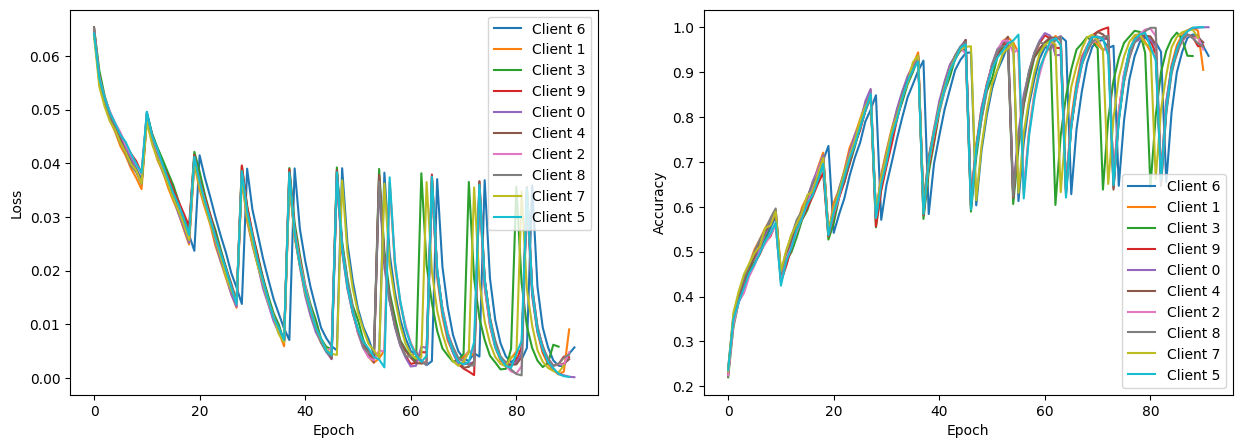

In [34]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

plot_metrics(strategy.client_metrics)

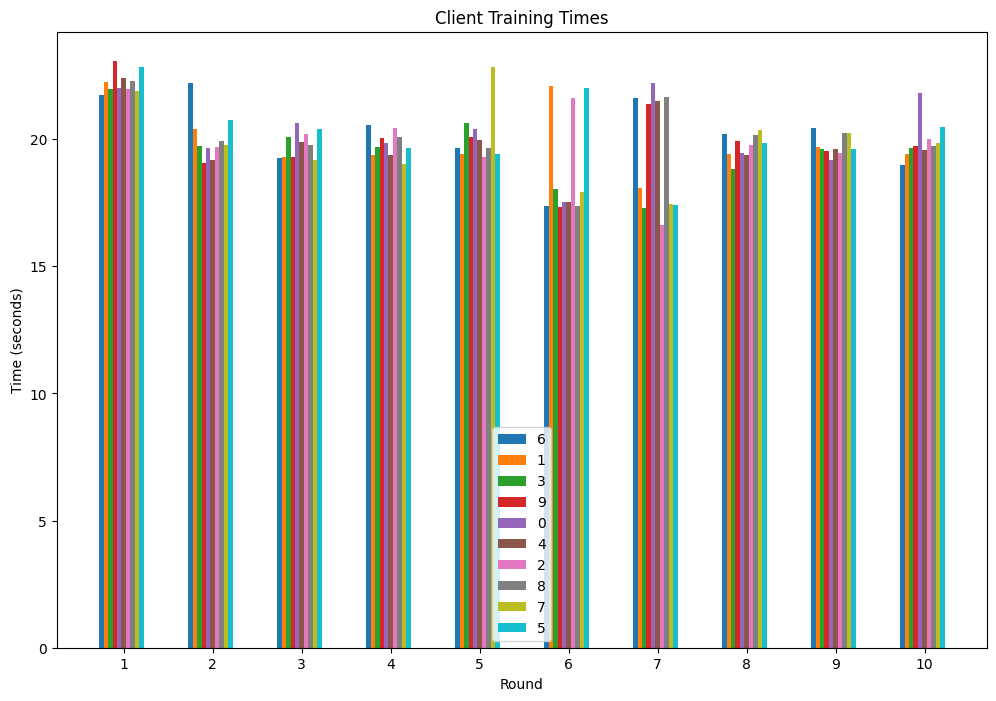

In [35]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [37]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 6 metrics: 92
Client 1 metrics: 91
Client 3 metrics: 89
Client 9 metrics: 91
Client 0 metrics: 92
Client 4 metrics: 91
Client 2 metrics: 91
Client 8 metrics: 91
Client 7 metrics: 90
Client 5 metrics: 91


In [22]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=5)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [23]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times = {}
        self.client_metrics = {}

    def parse_metrics(self, cid, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=10,
#     config=fl.server.ServerConfig(num_rounds=10),
#     client_resources=client_resources,
# )

In [24]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-11 12:48:20,457	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 67553327309.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 33237140275.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38504) [Client 2] get_parameters
(ClientAppActor pid=38504) [Client 4] fit, config: {}
(ClientAppActor pid=38504) Epoch 0: train loss 0.064795, accuracy 0.242000
(ClientAppActor pid=38504) Epoch 1: train loss 0.055655, accuracy 0.344667
(ClientAppActor pid=38960) [Client 6] fit, config: {}
(ClientAppActor pid=38504) Epoch 2: train loss 0.051042, accuracy 0.397111
(ClientAppActor pid=7856) [Client 7] fit, config: {}
(ClientAppActor pid=38960) Epoch 0: train loss 0.065239, accuracy 0.217778
(ClientAppActor pid=16860) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39056) Epoch 0: train loss 0.065487, accuracy 0.223778 [repeated 10x across cluster]
(ClientAppActor pid=17276) [Client 9] fit, config: {}
(ClientAppActor pid=38960) [Client 1] fit, config: {}
(ClientAppActor pid=38504) Epoch 2: train loss 0.051667, accuracy 0.396222 [repeated 19x across cluster]
(ClientAppActor pid=38960) Epoch 2: train loss 0.050655, accuracy 0.410444 [repeated 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38960) [Client 9] evaluate, config: {}
(ClientAppActor pid=38960) Epoch 4: train loss 0.045578, accuracy 0.464000 [repeated 3x across cluster]
(ClientAppActor pid=38960) Client 9 loss 0.05574746823310852
(ClientAppActor pid=38960) Client 9 accuracy 0.38
(ClientAppActor pid=39056) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39056) Client 8 loss 0.0544143705368042 [repeated 4x across cluster]
(ClientAppActor pid=39056) Client 8 accuracy 0.4 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=38960) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38960) Client 7 loss 0.05338778567314148 [repeated 5x across cluster]
(ClientAppActor pid=38960) Client 7 accuracy 0.412 [repeated 5x across cluster]
(ClientAppActor pid=38960) [Client 5] fit, config: {}
(ClientAppActor pid=38960) Epoch 0: train loss 0.049653, accuracy 0.414000
(ClientAppActor pid=38504) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38504) Epoch 0: train loss 0.048322, accuracy 0.441111 [repeated 8x across cluster]
(ClientAppActor pid=16860) [Client 2] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=13608) Epoch 3: train loss 0.040899, accuracy 0.522667 [repeated 17x across cluster]
(ClientAppActor pid=28108) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39056) Epoch 4: train loss 0.040384, accuracy 0.535556 [repeated 17x across cluster]
(ClientAppActor pid=38960) Epoch 4: train loss 0.038319, accuracy 0.557778 [repeated 6x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28108) [Client 7] evaluate, config: {}
(ClientAppActor pid=28108) Client 7 loss 0.04214132809638977
(ClientAppActor pid=28108) Client 7 accuracy 0.51
(ClientAppActor pid=28108) Epoch 4: train loss 0.040445, accuracy 0.527556
(ClientAppActor pid=17276) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17276) Client 0 loss 0.04498545980453491 [repeated 4x across cluster]
(ClientAppActor pid=17276) Client 0 accuracy 0.47 [repeated 4x across cluster]
(ClientAppActor pid=28108) [Client 3] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16860) Client 5 loss 0.04202470088005066 [repeated 5x across cluster]
(ClientAppActor pid=16860) Client 5 accuracy 0.496 [repeated 5x across cluster]
(ClientAppActor pid=16860) [Client 1] fit, config: {}
(ClientAppActor pid=16860) Epoch 0: train loss 0.043166, accuracy 0.510222
(ClientAppActor pid=16860) [Client 5] evaluate, config: {}
(ClientAppActor pid=38960) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39056) Epoch 2: train loss 0.036492, accuracy 0.585778 [repeated 9x across cluster]
(ClientAppActor pid=7856) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7856) Epoch 1: train loss 0.040599, accuracy 0.529778 [repeated 18x across cluster]
(ClientAppActor pid=39056) [Client 6] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16860) Epoch 2: train loss 0.037212, accuracy 0.578000 [repeated 16x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39056) Epoch 4: train loss 0.033575, accuracy 0.613556 [repeated 6x across cluster]
(ClientAppActor pid=39056) [Client 1] evaluate, config: {}
(ClientAppActor pid=39056) Client 1 loss 0.04107570838928223
(ClientAppActor pid=39056) Client 1 accuracy 0.542
(ClientAppActor pid=38504) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38504) Client 0 loss 0.042167364358901976 [repeated 4x across cluster]
(ClientAppActor pid=38504) Client 0 accuracy 0.536 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      


(ClientAppActor pid=39056) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39056) Client 2 loss 0.04485661005973816 [repeated 5x across cluster]
(ClientAppActor pid=39056) Client 2 accuracy 0.492 [repeated 5x across cluster]
(ClientAppActor pid=39056) [Client 0] fit, config: {}
(ClientAppActor pid=39056) Epoch 0: train loss 0.038978, accuracy 0.548667
(ClientAppActor pid=16860) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38960) Epoch 0: train loss 0.040826, accuracy 0.537333 [repeated 11x across cluster]
(ClientAppActor pid=7856) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=38960) Epoch 2: train loss 0.034236, accuracy 0.624667 [repeated 15x across cluster]
(ClientAppActor pid=28108) [Client 7] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=7856) Epoch 4: train loss 0.026383, accuracy 0.705333 [repeated 17x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28108) Epoch 4: train loss 0.026162, accuracy 0.701333 [repeated 6x across cluster]
(ClientAppActor pid=28108) [Client 5] evaluate, config: {}
(ClientAppActor pid=28108) Client 5 loss 0.03709829771518707
(ClientAppActor pid=28108) Client 5 accuracy 0.588
(ClientAppActor pid=38960) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38960) Client 3 loss 0.04086997485160827 [repeated 4x across cluster]
(ClientAppActor pid=38960) Client 3 accuracy 0.572 [repeated 4x across cluster]
(ClientAppActor pid=28108) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28108) Client 9 loss 0.04066553151607513 [repeated 4x across cluster]
(ClientAppActor pid=28108) Client 9 accuracy 0.556 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39056) [Client 2] fit, config: {}
(ClientAppActor pid=39056) [Client 0] evaluate, config: {}
(ClientAppActor pid=39056) Client 0 loss 0.04145441913604736
(ClientAppActor pid=39056) Client 0 accuracy 0.534
(ClientAppActor pid=39056) Epoch 0: train loss 0.037113, accuracy 0.582000
(ClientAppActor pid=38504) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28108) Epoch 0: train loss 0.037842, accuracy 0.564000 [repeated 11x across cluster]
(ClientAppActor pid=7856) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=13608) Epoch 3: train loss 0.026737, accuracy 0.702444 [repeated 13x across cluster]
(ClientAppActor pid=17276) [Client 8] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39056) Epoch 2: train loss 0.028915, accuracy 0.672222 [repeated 19x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17276) Epoch 4: train loss 0.021827, accuracy 0.751556 [repeated 6x across cluster]
(ClientAppActor pid=17276) [Client 2] evaluate, config: {}
(ClientAppActor pid=17276) Client 2 loss 0.04374217939376831
(ClientAppActor pid=17276) Client 2 accuracy 0.56
(ClientAppActor pid=38960) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38960) Client 3 loss 0.04194747793674469 [repeated 4x across cluster]
(ClientAppActor pid=38960) Client 3 accuracy 0.576 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13608) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39056) Client 5 loss 0.03737945640087128 [repeated 4x across cluster]
(ClientAppActor pid=39056) Client 5 accuracy 0.616 [repeated 4x across cluster]
(ClientAppActor pid=13608) [Client 1] fit, config: {}
(ClientAppActor pid=13608) Epoch 0: train loss 0.034549, accuracy 0.608222
(ClientAppActor pid=13608) Client 8 loss 0.04065118026733398
(ClientAppActor pid=13608) Client 8 accuracy 0.538
(ClientAppActor pid=38504) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=17276) Epoch 0: train loss 0.034977, accuracy 0.600222 [repeated 11x across cluster]
(ClientAppActor pid=16860) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17276) Epoch 2: train loss 0.025339, accuracy 0.712889 [repeated 15x across cluster]
(ClientAppActor pid=28108) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=16860) Epoch 4: train 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28108) Epoch 4: train loss 0.018595, accuracy 0.797111 [repeated 6x across cluster]
(ClientAppActor pid=28108) [Client 2] evaluate, config: {}
(ClientAppActor pid=28108) Client 2 loss 0.04409228718280792
(ClientAppActor pid=28108) Client 2 accuracy 0.544
(ClientAppActor pid=17276) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17276) Client 8 loss 0.040938806533813474 [repeated 4x across cluster]
(ClientAppActor pid=17276) Client 8 accuracy 0.552 [repeated 4x across cluster]
(ClientAppActor pid=28108) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28108) Client 3 loss 0.04333913099765778 [repeated 4x across cluster]
(ClientAppActor pid=28108) Client 3 accuracy 0.57 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13608) [Client 2] fit, config: {}
(ClientAppActor pid=13608) Epoch 0: train loss 0.034200, accuracy 0.617556
(ClientAppActor pid=13608) [Client 1] evaluate, config: {}
(ClientAppActor pid=13608) Client 1 loss 0.03815522348880768
(ClientAppActor pid=13608) Client 1 accuracy 0.606
(ClientAppActor pid=17276) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17276) Epoch 0: train loss 0.033311, accuracy 0.628444 [repeated 8x across cluster]
(ClientAppActor pid=7856) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=17276) Epoch 3: train loss 0.017759, accuracy 0.804444 [repeated 21x across cluster]
(ClientAppActor pid=38504) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=7856) Epoch 4: train loss 0.016354, accuracy 0.823111 [repeated 15x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38504) Epoch 4: train loss 0.015908, accuracy 0.826667 [repeated 5x across cluster]
(ClientAppActor pid=38504) [Client 4] evaluate, config: {}
(ClientAppActor pid=38504) Client 4 loss 0.043201645374298096
(ClientAppActor pid=38504) Client 4 accuracy 0.562
(ClientAppActor pid=16860) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38960) Client 8 loss 0.04285898804664612 [repeated 4x across cluster]
(ClientAppActor pid=38960) Client 8 accuracy 0.574 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13608) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13608) Client 9 loss 0.04412477457523346 [repeated 5x across cluster]
(ClientAppActor pid=13608) Client 9 accuracy 0.588 [repeated 5x across cluster]
(ClientAppActor pid=13608) [Client 3] fit, config: {}
(ClientAppActor pid=13608) Epoch 0: train loss 0.033615, accuracy 0.620667
(ClientAppActor pid=38504) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38504) Epoch 0: train loss 0.033911, accuracy 0.621111 [repeated 8x across cluster]
(ClientAppActor pid=28108) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7856) Epoch 4: train loss 0.011799, accuracy 0.874444 [repeated 20x across cluster]
(ClientAppActor pid=39056) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=13608) Epoch 2: train loss 0.020531, accuracy 0.771556 [repeated 14x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39056) Epoch 4: train loss 0.013465, accuracy 0.861333 [repeated 7x across cluster]
(ClientAppActor pid=39056) [Client 7] evaluate, config: {}
(ClientAppActor pid=39056) Client 7 loss 0.04293958687782288
(ClientAppActor pid=39056) Client 7 accuracy 0.588
(ClientAppActor pid=16860) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=16860) Client 9 loss 0.044488837361335756 [repeated 4x across cluster]
(ClientAppActor pid=16860) Client 9 accuracy 0.582 [repeated 4x across cluster]
(ClientAppActor pid=39056) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7856) Client 5 loss 0.0408074357509613 [repeated 3x across cluster]
(ClientAppActor pid=7856) Client 5 accuracy 0.632 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28108) [Client 2] fit, config: {}
(ClientAppActor pid=28108) [Client 0] evaluate, config: {}
(ClientAppActor pid=28108) Client 0 loss 0.045095956206321716 [repeated 2x across cluster]
(ClientAppActor pid=28108) Client 0 accuracy 0.554 [repeated 2x across cluster]
(ClientAppActor pid=28108) Epoch 0: train loss 0.032139, accuracy 0.642222
(ClientAppActor pid=17276) [Client 6] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39056) Epoch 0: train loss 0.031468, accuracy 0.646000 [repeated 8x across cluster]
(ClientAppActor pid=13608) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38960) Epoch 3: train loss 0.014115, accuracy 0.853333 [repeated 17x across cluster]
(ClientAppActor pid=7856) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=28108) Epoch 2: train loss 0.017129, accuracy 0.814222 [repeated 18x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=7856) Epoch 4: train loss 0.011620, accuracy 0.876444 [repeated 6x across cluster]
(ClientAppActor pid=7856) [Client 9] evaluate, config: {}
(ClientAppActor pid=7856) Client 9 loss 0.04685207986831665
(ClientAppActor pid=7856) Client 9 accuracy 0.586
(ClientAppActor pid=39056) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=17276) Client 0 loss 0.04770667946338653 [repeated 4x across cluster]
(ClientAppActor pid=17276) Client 0 accuracy 0.572 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28108) [Client 1] fit, config: {}
(ClientAppActor pid=28108) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=28108) Client 2 loss 0.048467553496360775 [repeated 5x across cluster]
(ClientAppActor pid=28108) Client 2 accuracy 0.552 [repeated 5x across cluster]
(ClientAppActor pid=28108) Epoch 0: train loss 0.030969, accuracy 0.659778
(ClientAppActor pid=39056) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38960) Epoch 0: train loss 0.032317, accuracy 0.637111 [repeated 11x across cluster]
(ClientAppActor pid=7856) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=17276) Epoch 4: train loss 0.009541, accuracy 0.903556 [repeated 15x across cluster]
(ClientAppActor pid=17276) [Client 6] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=7856) Epoch 4: train loss 0.009457, accuracy 0.902667 [repeated 17x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17276) Epoch 4: train loss 0.009397, accuracy 0.903778 [repeated 6x across cluster]
(ClientAppActor pid=17276) [Client 2] evaluate, config: {}
(ClientAppActor pid=17276) Client 2 loss 0.052256683707237246
(ClientAppActor pid=17276) Client 2 accuracy 0.56
(ClientAppActor pid=38960) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13608) Client 8 loss 0.04675095927715302 [repeated 3x across cluster]
(ClientAppActor pid=13608) Client 8 accuracy 0.588 [repeated 3x across cluster]
(ClientAppActor pid=17276) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38504) Client 9 loss 0.049078866720199586 [repeated 4x across cluster]
(ClientAppActor pid=38504) Client 9 accuracy 0.6 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 397.24s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0546904938697815
INFO :      		round 2: 0.044297043251991276
INFO :      		round 3: 0.04154509165287018
INFO :      		round 4: 0.0402956542134285
INFO :      		round 5: 0.04038473962545395
INFO :      		round 6: 0.041080852341651916
INFO :      		round 7: 0.04311245458126068
INFO :      		round 8: 0.04403579086065292
INFO :      		round 9: 0.046386909067630766
INFO :      		round 10: 0.04900659232139588
INFO :      


History (loss, distributed):
	round 1: 0.0546904938697815
	round 2: 0.044297043251991276
	round 3: 0.04154509165287018
	round 4: 0.0402956542134285
	round 5: 0.04038473962545395
	round 6: 0.041080852341651916
	round 7: 0.04311245458126068
	round 8: 0.04403579086065292
	round 9: 0.046386909067630766
	round 10: 0.04900659232139588

(ClientAppActor pid=28108) Client 4 loss 0.049690425157547
(ClientAppActor pid=28108) Client 4 accuracy 0.568


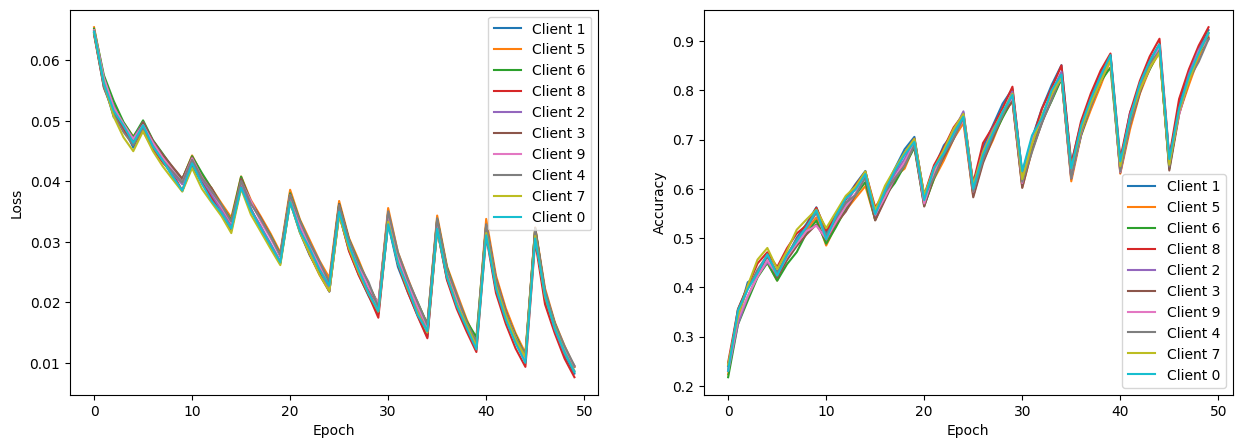

In [26]:
plot_metrics(strategy_fed_avg.client_metrics)

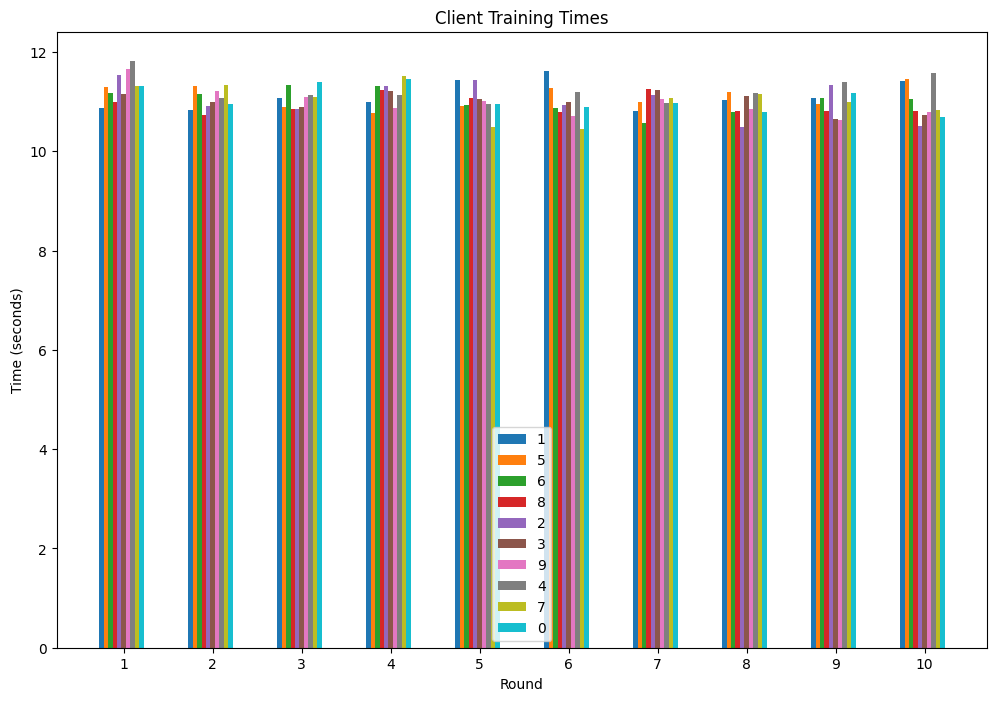

In [27]:
plot_times(strategy_fed_avg.client_training_times)

In [ ]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
)